In [ ]:
import numpy as np
import torch
import matplotlib.pyplot as plt
from tqdm import tqdm
import sys
import pickle
from julia.api import Julia
from sklearn.preprocessing import MinMaxScaler
import string

from rno_wrapper import RNOWrapper

In [2]:
def get_index_from_time(T_min, T_max, query_time, arr_size):
    """
    Given array with data spanning from time T_min to T_max, return the index in the array
    associated with query_time.
    """
    time_range = T_max - T_min
    return round(arr_size * (query_time - T_min) / time_range)

def round_down(num, divisor): # rounds `num` down to nearest multiple of `divisor`
    return num - (num % divisor)

# Setup Julia

In [3]:
jl = Julia(compiled_modules=False)

J = lambda x : jl.eval(x)

In [4]:
J("using MixedLayerModel")

In [5]:
def numpy_to_julia_str(arr):
    """
    Converts numpy array to Julia Vector command
    """
    return np.array2string(arr, separator=',').replace(' ', '').replace('\n','')

def julia_str_to_numpy(input_str):
    """
    Converts Julia Vector command string to numpy array
    """
    allowed_chars = set(string.digits + '.' + ' ' + '[' + ']' + ',') # set of allowed characters to build some security into `eval` call
    assert set(input_str) <= allowed_chars
    
    try:
        return np.array(eval(input_str))
    except:
        raise RuntimeError("Improper syntax")

# Define PDE Loss

In [6]:
# Define parameters

J("par = upCO2();")
J("par.etype = enBal();")
J("par.fttype = co2EIS();")
J("par.rtype = varRad();")
J("par.Cd = 7.9e-4;") 
J("par.α_vent = 1.69e-3;")
J("par.SW_b = 140;")
J("par.stype = varSST();")
J("par.ctype = stochvarCO2();")
J("par.CO2_rate = 0.1;")
J("par.OHU = -12.060032263796472;")

-12.060032263796472

In [7]:
def time_deriv_nonper(u, dt):
    """
    Finite difference method to compute time derivative of nonperiodic function
    """
    return (u[:, 2:, :] - u[:, :-2, :]) / (2 * dt)

In [8]:
def cloud_cover_deriv(u, co2):
    """
        `u` shape (timesteps, dim)
        `co2` shape (timesteps, 1)
    """
    assert u.shape[0] == co2.shape[0]
    deriv_list = []

    for i in range(len(u)):
        du_i_str = numpy_to_julia_str(np.zeros(u.shape[-1]))
        J("du = " + du_i_str + ";")
        u_i_str = numpy_to_julia_str(u[i])
        co2_i_str = str(co2[i,0])
        julia_command = "mlm2(du, " + u_i_str + ", par, " + co2_i_str + ");"
        
        J(julia_command)
        deriv_list.append(np.array(J("du")))

    return np.array(deriv_list)

In [23]:
def partial_PDE_loss(u, co2, t_step, index=0, normalize=False):
    """
        `u` shape: (batch_size, time_steps, dim)
        `co2` shape: (batch_size, time_steps, 1)
        `index`: index of `dim` across which to compare model's derivative with equation
        `normalize`: whether to component-wise normalize 
            the derivative by the component-wise 
            absolute value of `u`
    """
    rhs_list = []

    for i in range(len(u)):
        rhs_list.append(cloud_cover_deriv(u[i], co2[i]))
    
    rhs = np.array(rhs_list)[:,1:-1,] # match dimensions to output of `time_deriv_nonper`
    u_t = time_deriv_nonper(u, t_step)
    
    if normalize:
        norm = np.abs(u[:,1:-1])
        rhs /= norm
        u_t /= norm
        
    diff = np.expand_dims(u_t[..., index] - rhs[..., index], axis=-1)
    
    return np.mean(np.linalg.norm(diff, axis=-1), axis=-1) # time-averaged within each window

# Helper Functions

In [9]:
def invert_state_scaling(u, scaler, forcing_dim=1):
    """
        The scaler is defined on the space (u, forcing). This helper function
        inverts the scaling (i.e., scales back to the original space) if forcing
        is not given.
        
        `forcing_dim` is the number of dimensions of the forcing.
    """
    output_shape = u.shape
    u = np.reshape(u, (-1, u.shape[-1]))
    u = np.concatenate([u, np.zeros((u.shape[0], forcing_dim))], axis=-1)
    
    unscaled_u = scaler.inverse_transform(u)[..., :-forcing_dim]
    
    return np.reshape(unscaled_u, output_shape)
    
    
def invert_forcing_scaling(forcing, scaler, state_dim=5):
    """
        The scaler is defined on the space (u, forcing). This helper function
        inverts the scaling (i.e., scales back to the original space) if state
        is not given.
        
        `state_dim` is the number of dimensions of the state.
    """
    output_shape = forcing.shape
    forcing = np.reshape(forcing, (-1, forcing.shape[-1]))
    forcing = np.concatenate([np.zeros((forcing.shape[0], state_dim)), forcing], axis=-1)
    
    unscaled_forcing = scaler.inverse_transform(forcing)[..., state_dim:]
    
    return np.reshape(unscaled_forcing, output_shape)

# Data Loading

We now load the testing data. We will compute the empirical CDF on 45 trajectories and predict the tipping point on 5 unseen trajectories.

In [10]:
sub = 1 # temporal subsampling rate
T = 128 # input last T time steps and output next T

n_intervals = 5 # number of intervals in each training example

in_dim = 5 + 1 # dimensionality of ODE + dimension of input parameter
out_dim = 5

In [11]:
# Data is of the shape (number of trajectories, number of samples, grid size)
data = np.load("PATH/TO/DATA.npy")
extra_calibration_data = np.load("PATH/TO/EXTRA/CALIBRATION/DATA/IF/NEEDED.npy")

tipping_point = 10.0 # time of tipping point (or -- time where tipping point is guaranteed to occur after)

dt = 1.0 / 365 # years
dt_sec = dt * 3600 * 24 * 365 # seconds
T1 = 0.0 # years
T2 = 20.0 # years
data = data[:,:-1] # Make shape easier to divide
extra_calibration_data = extra_calibration_data[:,:-1]

num_traj = data.shape[0]
traj_len = data.shape[1]

train_trajectories = 50
data_test_trajectories = 50
test_trajectories = len(data) + len(extra_calibration_data) - train_trajectories

# Min-max scaling
scaler = MinMaxScaler()
scaler.fit(np.reshape(data[:train_trajectories], (train_trajectories * traj_len, in_dim))) # fit on training set
data = scaler.transform(np.reshape(data, (num_traj * traj_len, in_dim)))
data = np.reshape(data, (num_traj, traj_len, in_dim))

extra_calibration_data = scaler.transform(np.reshape(extra_calibration_data, (-1, in_dim)))
extra_calibration_data = np.reshape(extra_calibration_data, (-1, traj_len, in_dim))

# Train-test split
test = data[-data_test_trajectories:]
test = np.concatenate([extra_calibration_data, test], axis=0)

# Make testing data easier to reshape
test_idx = round_down(test.shape[1], T)
test = test[:,:test_idx]

test = np.reshape(test, (test_trajectories, -1, T, in_dim))

In [12]:
num_val = 145
num_test = 5

val = torch.tensor(test[:num_val])
test = torch.tensor(test[-num_test:])

# Empirical CDF analysis

In [13]:
comp_steps = 7 # number of steps to compose model
comp_offset = comp_steps * dt * T

pde_loss_samples = []

In [14]:
# Tipping point adjusted for number of composition steps `comp_steps`
adjusted_tipping_point = tipping_point - comp_offset

tipping_idx = get_index_from_time(T1, T2, adjusted_tipping_point, val.shape[1])
pre_tipping_val = val[:,:tipping_idx]

pre_tipping_val = torch.reshape(pre_tipping_val, (num_val, -1, T, in_dim))
test = torch.reshape(test, (num_test, -1, T, in_dim))

# Generate input time-steps
pre_tipping_val_list = []
pre_tipping_val_forcing_list = []
test_list = []
test_forcing_list = []

for traj in pre_tipping_val:
    traj_list = []
    forcing_list = []
    for i in range(pre_tipping_val.shape[1] - n_intervals - comp_steps):
        traj_list.append(traj[i:i + n_intervals])
        forcing_list.append(traj[i + n_intervals : i + n_intervals + comp_steps, ..., -1])
        
    pre_tipping_val_list.append(torch.stack(traj_list, 0))
    pre_tipping_val_forcing_list.append(torch.stack(forcing_list, 0))

for traj in test:
    traj_list = []
    forcing_list = []
    for i in range(test.shape[1] - n_intervals - comp_steps):
        traj_list.append(traj[i:i + n_intervals])
        forcing_list.append(traj[i + n_intervals : i + n_intervals + comp_steps, ..., -1])
    
    test_list.append(torch.stack(traj_list, 0))
    test_forcing_list.append(torch.stack(forcing_list, 0))

pre_tipping_val = torch.stack(pre_tipping_val_list, 0).float()
pre_tipping_forcing = torch.stack(pre_tipping_val_forcing_list, 0).unsqueeze(-1).float()
test = torch.stack(test_list, 0).float()
test_forcing = torch.stack(test_forcing_list, 0).unsqueeze(-1).float()

### Computing eCDF

In [15]:
input_forcing = False

model = torch.load('PATH/TO/MODEL', map_location=torch.device("cpu"))

In [ ]:
model.eval()

with torch.no_grad():
    for i in range(len(pre_tipping_val)): # compute eCDF on validation set
        x_batch = pre_tipping_val[i]
        forcing = pre_tipping_forcing[i]
        
        u = model.predict(x_batch, comp_steps, forcing=forcing[:,:-1]) # forcing[:,:-1] to pass in the relevant forcing terms
        u = u.reshape((x_batch.shape[0], -1, out_dim)).numpy()
        forcing = np.reshape(forcing, (forcing.shape[0], -1, 1))
        
        u = invert_state_scaling(u, scaler)
        forcing = invert_forcing_scaling(forcing, scaler)
        pde_loss_samples.append(partial_PDE_loss(u, forcing, dt))
        print("Completed " + str(i + 1) + "/" + str(len(pre_tipping_val)))

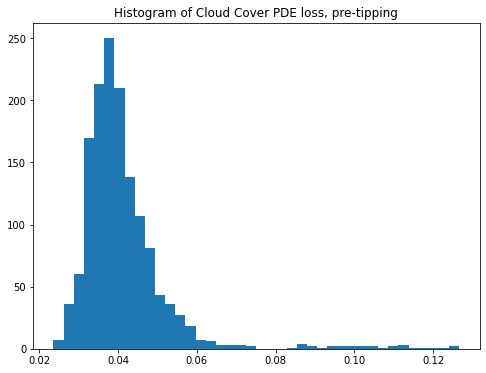

In [25]:
plt.figure(figsize=(8,6))
plt.hist(pde_loss_samples, bins=40)
plt.title("Histogram of Cloud Cover PDE loss, pre-tipping")
plt.show()

In [26]:
ecdf = lambda x: np.sum(pde_loss_samples < x) / len(pde_loss_samples)

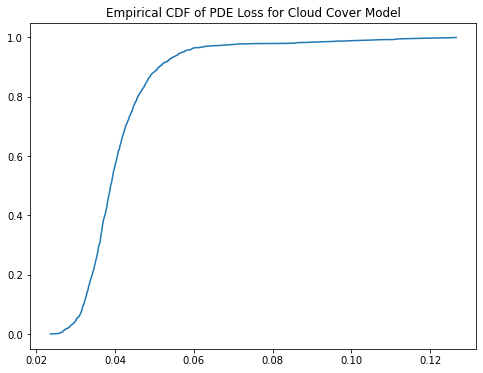

In [27]:
plt.figure(figsize=(8,6))
plt.plot(np.sort(pde_loss_samples), np.linspace(0, 1, len(pde_loss_samples), endpoint=False))
plt.title("Empirical CDF of PDE Loss for Cloud Cover Model")
plt.show()

# DKW Analysis

We would like to bound the location of the true CDF $F(x)$ within some interval $F_n(x) - \varepsilon \leq F(x) \leq F_n(x) + \varepsilon$ of the empirical CDF $F_n(x)$ for all $x$. In fact, using the DKW inequality, we find that with probability $1 - \beta$, the true CDF $F(x)$ differs by at most $\varepsilon$ from $F_n(x)$.

In particular, the DKW inequality tells us that $$\varepsilon = \sqrt{\frac{\ln \frac{2}{\beta}}{2n}}.$$

In [28]:
beta = 1e-3

In [29]:
eps = np.sqrt(np.log(2 / beta) / (2 * len(pde_loss_samples)))
print(eps)

0.05119571122777727


When predicting whether a tipping point has occurred, we would like to "call" a tipping point if the lower bound of the DKW inequality is greater than $1-\alpha$, for some significance value $\alpha$. That is, we call a tipping point if and only if $F_n(x) - \varepsilon > 1-\alpha \iff \alpha > 1 - F_n(x) + \varepsilon$.

In [45]:
alpha = 0.07

In [31]:
test_idx = 0

In [28]:
traj = test[test_idx]
forcing = test_forcing[test_idx]

with torch.no_grad():
    t_mins = np.arange(T1, T2, T * dt)[:traj.shape[0]] + n_intervals * T * dt

    if input_forcing:
        u = model.predict(traj, comp_steps, forcing=forcing[:,:-1])
    else:
        u = model.predict(traj[..., :-1], comp_steps)
        
    u = u[:,-1].reshape((traj.shape[0], T, out_dim)).numpy()
    forcing = np.reshape(forcing[:,-1], (forcing.shape[0], T, 1))
    
    u = invert_state_scaling(u, scaler)
    forcing = invert_forcing_scaling(forcing, scaler)
    
    loss = partial_PDE_loss(u, forcing, dt, normalize=True)

In [46]:
# Find true tipping point for this trajectory -- when cloud cover crosses 0.6
cf_critical_val = 0.6
true_tipping_point = T1 + (n_intervals - 1) * T * dt

traj_cloud_cover = scaler.inverse_transform(torch.reshape(test[test_idx,:,-1], (-1, in_dim)))[:, 4]

for i in range(len(traj_cloud_cover) - 1):
    if traj_cloud_cover[i] > cf_critical_val and traj_cloud_cover[i+1] < cf_critical_val:
        true_tipping_point += (2 * i + 1) / 2 * dt
        break

assert true_tipping_point > T1 + (n_intervals - 1) * T * dt

In [47]:
print("Offset from start caused by composing model:", comp_offset)

Offset from start caused by composing model: 2.4547945205479453


In [53]:
tipping_time = np.inf
t_mins = np.arange(T1, T2, T * dt)[:traj.shape[0]] + n_intervals * T * dt # n_intervals warm up time

for loss_val, time in zip(loss, t_mins):
    if alpha >= 1 - ecdf(loss_val) + eps:
        tipping_time = time
        break

if tipping_time != np.inf:
    print("Predicted tipping point: %.2f" % tipping_time)
else:
    print("No tipping point found")

Predicted tipping point: 7.72


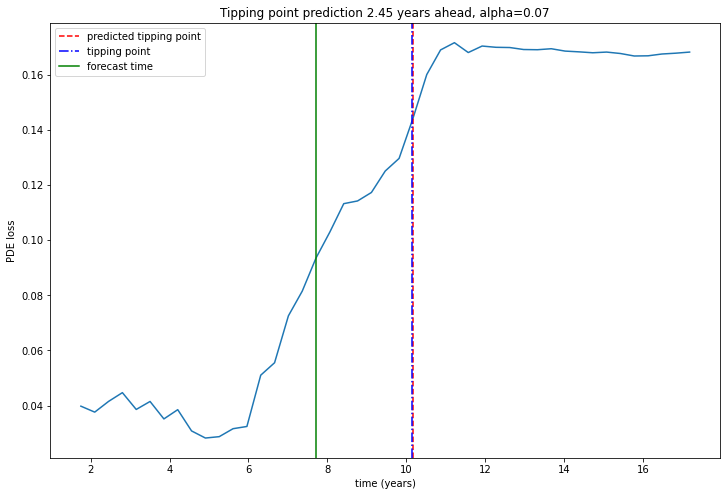

In [49]:
plt.figure(figsize=(12,8))
plt.plot(t_mins[:len(loss)], loss)
plt.axvline(x = tipping_time + comp_offset, color='r', ls='--', label = 'predicted tipping point')
plt.axvline(x = true_tipping_point, color='b', ls='-.', label = 'tipping point')
plt.axvline(x = tipping_time, color='g', ls='-', label = 'forecast time')
plt.title("Tipping point prediction {} years ahead, alpha={}".format((round(comp_offset, 2)), alpha))
plt.xlabel('time (years)')
plt.ylabel('PDE loss')
#plt.ylim([0, 5 * np.max(pde_loss_samples)])
plt.legend()
plt.show()

In [56]:
print("True tipping point: %.2f" % true_tipping_point)

True tipping point: 10.14


In [57]:
print("Error in tipping point prediction: %.2f" % ((tipping_time + comp_offset) - true_tipping_point))

Error in tipping point prediction: 0.03


# Paper Figures

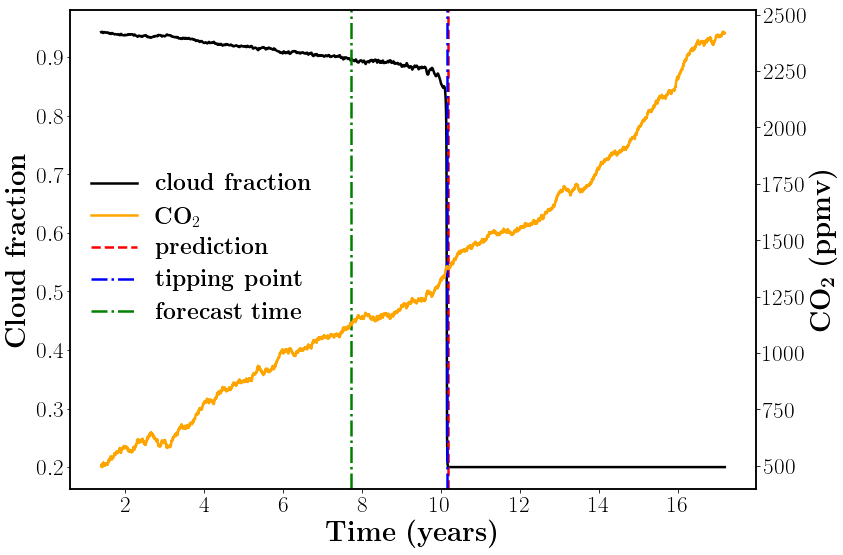

In [60]:
from matplotlib import rc

# Set LaTeX font rendering
rc('text', usetex=True)

# Set style parameters for a professional look
plt.rcParams['font.family'] = 'serif'
plt.rcParams['font.size'] = 16
plt.rcParams['axes.linewidth'] = 1.5
plt.rcParams['lines.linewidth'] = 2.5

# Set figure size and create the plot
temp = scaler.inverse_transform(torch.reshape(test[test_idx,:,-1], (-1, in_dim)))
t = np.arange(T1, T2, dt)[:temp.shape[0]] + (n_intervals - 1) * T * dt
#plt.plot(t, temp[:,4])

# Create the first plot
fig, ax1 = plt.subplots(figsize=(12, 8))
line1 = ax1.plot(t, temp[:,4], 'black', label=r'\textbf{cloud fraction}')
ax1.set_xlabel(r'\textbf{Time (years)}', fontsize='xx-large')
ax1.set_ylabel(r'\textbf{Cloud fraction}', fontsize='xx-large')
ax1.tick_params(labelsize='x-large')

# Create the second plot
ax2 = ax1.twinx()
line2 = ax2.plot(t, temp[:,-1], 'orange', label=r'\textbf{CO$_2$}')
ax2.set_ylabel(r'\textbf{CO}$\mathbf{_2}$ \textbf{(ppmv)}', fontsize='xx-large')
ax2.tick_params(labelsize='x-large')

line3 = ax1.axvline(x = tipping_time + comp_offset, color='r', ls='--', label = r'\textbf{prediction}')
line4 = ax1.axvline(x = true_tipping_point, color='b', ls='-.', label = r'\textbf{tipping point}')
line5 = ax1.axvline(x = tipping_time, color='g', ls='-.', label = r'\textbf{forecast time}')

# Legend -- inspired from https://stackoverflow.com/questions/5484922/secondary-axis-with-twinx-how-to-add-to-legend
lines = line1 + line2 + [line3] + [line4] + [line5]
labels = [l.get_label() for l in lines]
legend = ax1.legend(lines, labels, loc='center left', fontsize='x-large')
legend.get_frame().set_linewidth(0)

# Show the plot
plt.tight_layout()

plt.savefig('rno_cloud_cover_no_forcing_partial_physics.pdf', format='pdf')
plt.show()

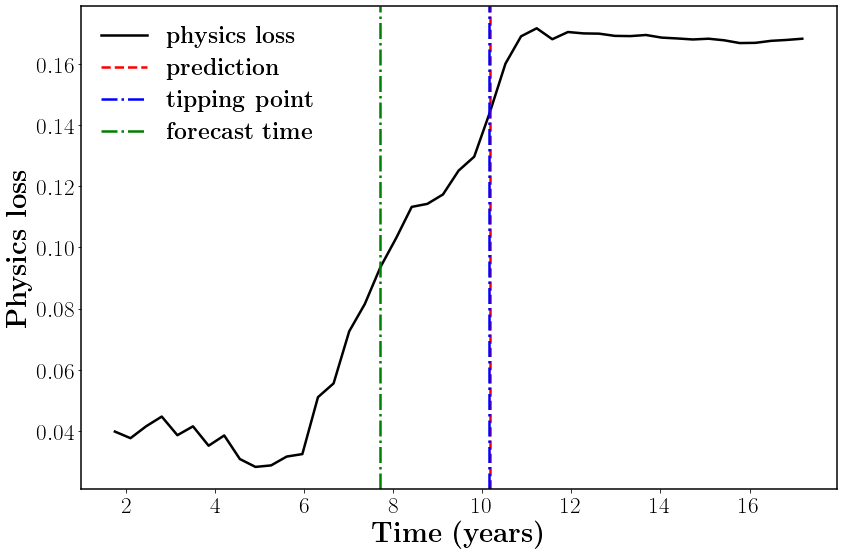

In [61]:
from matplotlib import rc

# Set LaTeX font rendering
rc('text', usetex=True)

# Set style parameters for a professional look
plt.rcParams['font.family'] = 'serif'
plt.rcParams['font.size'] = 16
plt.rcParams['axes.linewidth'] = 1.5
plt.rcParams['lines.linewidth'] = 2.5

# Set figure size and create the plot
plt.figure(figsize=(12, 8))

# Plot the data
plt.plot(t_mins[:len(loss)], loss, color='black', label=r'\textbf{physics loss}')
plt.axvline(x=tipping_time + comp_offset, color='r', ls='--', label=r'\textbf{prediction}')
plt.axvline(x=true_tipping_point, color='b', ls='-.', label=r'\textbf{tipping point}')
plt.axvline(x=tipping_time, color='green', ls='-.', label=r'\textbf{forecast time}')

# Set title and labels
plt.xlabel(r'\textbf{Time (years)}', fontsize='xx-large')
plt.ylabel(r'\textbf{Physics loss}', fontsize='xx-large')

#plt.title(r"\textbf{RNO}", fontsize='xx-large')

# Customize legend
legend = plt.legend(loc='best', fontsize='x-large', frameon=False)
legend.get_frame().set_linewidth(0)

# Adjust tick label size
plt.xticks(fontsize='x-large')
plt.yticks(fontsize='x-large')

# Show the plot
plt.tight_layout()
plt.savefig('rno_cloud_cover_no_forcing_partial_physics_loss.pdf', format='pdf')
plt.show()

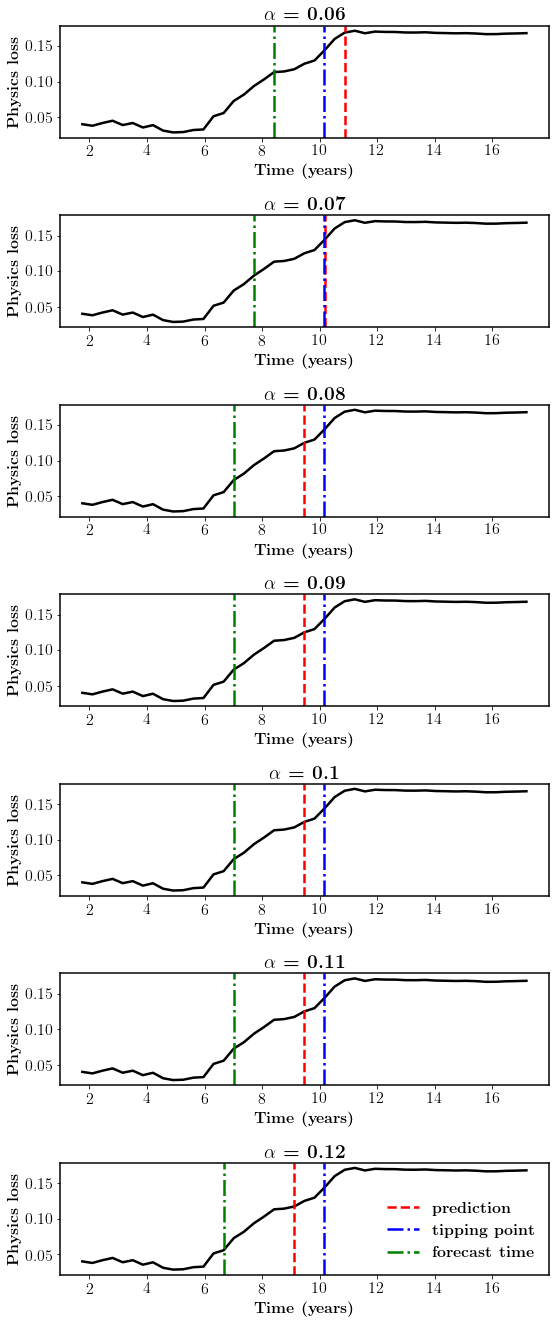

In [50]:
from matplotlib import rc

# Set LaTeX font rendering
rc('text', usetex=True)

# Set style parameters for a professional look
plt.rcParams['font.family'] = 'serif'
plt.rcParams['font.size'] = 16
plt.rcParams['axes.linewidth'] = 1.5
plt.rcParams['lines.linewidth'] = 2.5

# Set figure size and create the plot
#alphas = [0.04, 0.05, 0.06, 0.07]
alphas = [0.06, 0.07, 0.08, 0.09, 0.1, 0.11, 0.12]
fig, axs = plt.subplots(len(alphas), 1, figsize=(8, 16 / 6 * len(alphas)))

for i in range(len(alphas)):
    a = alphas[i]
    ax = axs[i]
    
    tipping_time = np.inf
    t_mins = np.arange(T1, T2, T * dt)[:traj.shape[0]] + n_intervals * T * dt # n_intervals warm up time

    for loss_val, time in zip(loss, t_mins):
        if a >= 1 - ecdf(loss_val) + eps:
            tipping_time = time
            break

    # Plot the data
    ax.plot(t_mins[:len(loss)], loss, color='black')
    ax.axvline(x=tipping_time + comp_offset, color='r', ls='--', label=r'\textbf{prediction}')
    ax.axvline(x=true_tipping_point, color='b', ls='-.', label=r'\textbf{tipping point}')
    ax.axvline(x=tipping_time, color='green', ls='-.', label=r'\textbf{forecast time}')

    # Set title and labels
    ax.set_title(r'\textbf{$\alpha$ = ' + str(a) + ' }')
    ax.set_xlabel(r'\textbf{Time (years)}')
    ax.set_ylabel(r'\textbf{Physics loss}')
    
# Customize legend
legend = axs[-1].legend(loc='best', frameon=False)
legend.get_frame().set_linewidth(0)    

# Show the plot
plt.tight_layout()
#plt.savefig('rno_clouds_tipping_varying_alpha.pdf', format='pdf')
plt.show()